In [1]:
import time
import random
import numpy as np
import pandas as pd
import networkx as nx
from scipy.io import mmread
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from collections import defaultdict

In [2]:
def load_graph_from_mtx(econmbeacxc):
    matrix = mmread("econ-mbeacxc.mtx").tocoo()
    G = nx.from_scipy_sparse_array(matrix)
    for u, v, d in G.edges(data=True):
        if "weight" not in d:
            d["weight"] = matrix.data[matrix.row == u][0] if matrix.row.shape[0] > 0 else 1
    return G


In [3]:
G = load_graph_from_mtx("econ-mbeacxc.mtx")

In [4]:
def print_network_summary(graph):
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    num_self_loops = nx.number_of_selfloops(graph)
    degrees = [deg for _, deg in graph.degree()]

    edge_weights = []
    for _, _, data in graph.edges(data=True):
        w = data.get("weight", 1.0)
        if w is not None:
            edge_weights.append(w)

    is_directed = nx.is_directed(graph)
    is_weighted = any("weight" in data for _, _, data in graph.edges(data=True))

    print("Number of nodes:", num_nodes)
    print("Number of edges (total):", num_edges)
    print("Number of self-loops:", num_self_loops)
    print("Number of edges (excluding self-loops):", num_edges - num_self_loops)
    print("Average degree:", sum(degrees) / len(degrees))
    print("Is directed:", is_directed)
    print("Is weighted:", is_weighted)

    if edge_weights:
        max_weight = max(edge_weights)
        min_weight = min(edge_weights)
        print("Maximum edge weight:", max_weight)
        print("Minimum edge weight:", min_weight)
    else:
        print("No edge weights found")


print_network_summary(G)

Number of nodes: 496
Number of edges (total): 42090
Number of self-loops: 404
Number of edges (excluding self-loops): 41686
Average degree: 169.71774193548387
Is directed: False
Is weighted: True
Maximum edge weight: 0.74266028
Minimum edge weight: -0.0018771


In [5]:
results = {'Kruskal': {},'Prim': {},'Boruvka': {},'Reverse-Delete': {},'Karger': {}}

In [6]:
def kruskal_mst(G):
    start = time.time()
    mst = nx.Graph()
    dsu = nx.utils.UnionFind()

    edges = sorted(G.edges(data=True), key=lambda x: x[2].get('weight', 1))
    for u, v, data in edges:
        if dsu[u] != dsu[v]:
            mst.add_edge(u, v, **data)
            dsu.union(u, v)

    duration = time.time() - start
    weight = sum(d["weight"] for _, _, d in mst.edges(data=True))
    results['Kruskal'] = {"Time": duration, "Total Weight": weight, "Num Edges": mst.number_of_edges()}
    return mst


In [7]:
import heapq

def prim_mst(G):
    start = time.time()
    visited = set()
    mst = nx.Graph()
    min_heap = []

    initial = list(G.nodes())[0]
    visited.add(initial)
    for v, data in G[initial].items():
        heapq.heappush(min_heap, (data.get("weight", 1), initial, v))

    while min_heap and len(visited) < G.number_of_nodes():
        weight, u, v = heapq.heappop(min_heap)
        if v not in visited:
            visited.add(v)
            mst.add_edge(u, v, weight=weight)
            for to, attr in G[v].items():
                if to not in visited:
                    heapq.heappush(min_heap, (attr.get("weight", 1), v, to))

    duration = time.time() - start
    weight = sum(d["weight"] for _, _, d in mst.edges(data=True))
    results['Prim'] = {"Time": duration, "Total Weight": weight, "Num Edges": mst.number_of_edges()}
    return mst


In [8]:
def boruvka_mst(G):
    start = time.time()

    if not nx.is_connected(G):
        raise ValueError("Borůvka requires a connected graph.")

    parent = {node: node for node in G.nodes}
    rank = {node: 0 for node in G.nodes}

    def find(u):
        if parent[u] != u:
            parent[u] = find(parent[u])
        return parent[u]

    def union(u, v):
        root_u, root_v = find(u), find(v)
        if root_u == root_v:
            return False
        if rank[root_u] < rank[root_v]:
            parent[root_u] = root_v
        elif rank[root_u] > rank[root_v]:
            parent[root_v] = root_u
        else:
            parent[root_v] = root_u
            rank[root_u] += 1
        return True

    mst = nx.Graph()
    num_components = G.number_of_nodes()

    while num_components > 1:
        cheapest = {}
        for u, v, data in G.edges(data=True):
            w = data.get("weight", 1)
            set_u = find(u)
            set_v = find(v)
            if set_u != set_v:
                if set_u not in cheapest or w < cheapest[set_u][2]:
                    cheapest[set_u] = (u, v, w)
                if set_v not in cheapest or w < cheapest[set_v][2]:
                    cheapest[set_v] = (u, v, w)

        merged_in_this_round = 0
        for u, v, w in set(cheapest.values()):
            if union(u, v):
                mst.add_edge(u, v, weight=w)
                num_components -= 1
                merged_in_this_round += 1

        print(f"Remaining components: {num_components}, Edges in MST: {mst.number_of_edges()}")

        if merged_in_this_round == 0:
            print("⚠️ Stuck: No components merged — check graph structure.")
            break

    duration = time.time() - start
    total_weight = sum(d["weight"] for _, _, d in mst.edges(data=True))
    results["Boruvka"] = {
        "Time": duration,
        "Total Weight": total_weight,
        "Num Edges": mst.number_of_edges(),
    }
    return mst


In [9]:
def reverse_delete_mst(G):
    start = time.time()
    mst = G.copy()
    edges = sorted(G.edges(data=True), key=lambda x: x[2].get("weight", 1), reverse=True)

    for u, v, data in edges:
        mst.remove_edge(u, v)
        if not nx.is_connected(mst):
            mst.add_edge(u, v, **data)

    duration = time.time() - start
    weight = sum(d["weight"] for _, _, d in mst.edges(data=True))
    results['Reverse-Delete'] = {"Time": duration, "Total Weight": weight, "Num Edges": mst.number_of_edges()}
    return mst


In [10]:
def karger_mst_approx(G):
    start = time.time()
    G_temp = G.copy()
    while len(G_temp.nodes) > 2:
        u, v = random.choice(list(G_temp.edges()))
        G_temp = nx.contracted_nodes(G_temp, u, v, self_loops=False)

    duration = time.time() - start
    total_weight = sum(d['weight'] for _, _, d in G_temp.edges(data=True))
    results['Karger'] = {"Time": duration, "Total Weight": total_weight, "Num Edges": G_temp.number_of_edges()}
    return G_temp


In [11]:
def run_mst_on_all_components(G, mst_func, algo_name):
    start = time.time()
    forest = nx.Graph()
    total_weight = 0
    total_edges = 0
    num_components = 0

    for component in nx.connected_components(G):
        if len(component) <= 1:
            continue  # skip isolated nodes

        subgraph = G.subgraph(component).copy()
        sub_mst = mst_func(subgraph)
        forest.add_edges_from(sub_mst.edges(data=True))

        total_weight += sum(d["weight"] for _, _, d in sub_mst.edges(data=True))
        total_edges += sub_mst.number_of_edges()
        num_components += 1

    duration = time.time() - start
    results[algo_name] = {
        "Time": duration,
        "Total Weight": total_weight,
        "Num Edges": total_edges,
        "Components": num_components
    }

    return forest


In [12]:
mst_graphs = {}

mst_graphs['Kruskal'] = run_mst_on_all_components(G, kruskal_mst, "Kruskal")

In [13]:
mst_graphs['Prim'] = run_mst_on_all_components(G, prim_mst, "Prim")

In [14]:
mst_graphs["Boruvka"] = run_mst_on_all_components(G, boruvka_mst, "Boruvka")


Remaining components: 12, Edges in MST: 475
Remaining components: 1, Edges in MST: 486


In [15]:
mst_graphs['Reverse-Delete'] = run_mst_on_all_components(G, reverse_delete_mst, "Reverse-Delete")

In [16]:
mst_graphs['Karger'] = run_mst_on_all_components(G, karger_mst_approx, "Karger")

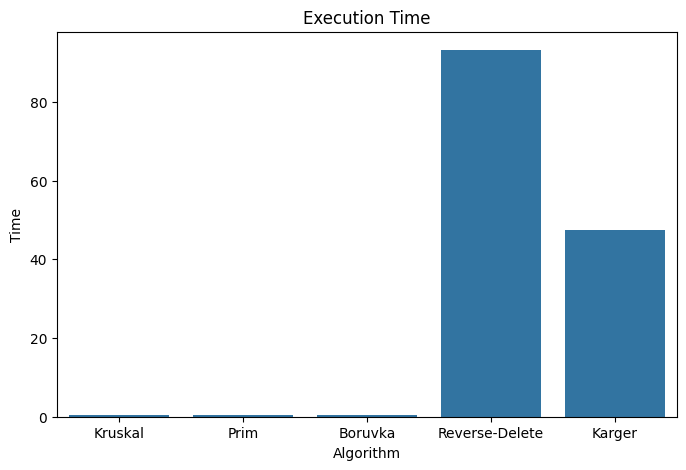

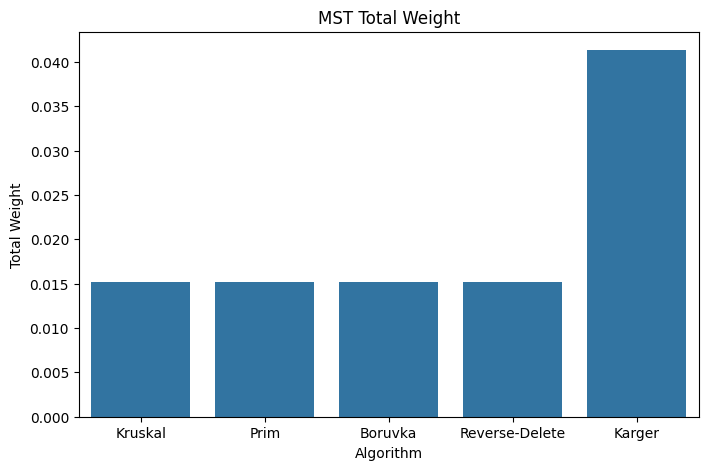

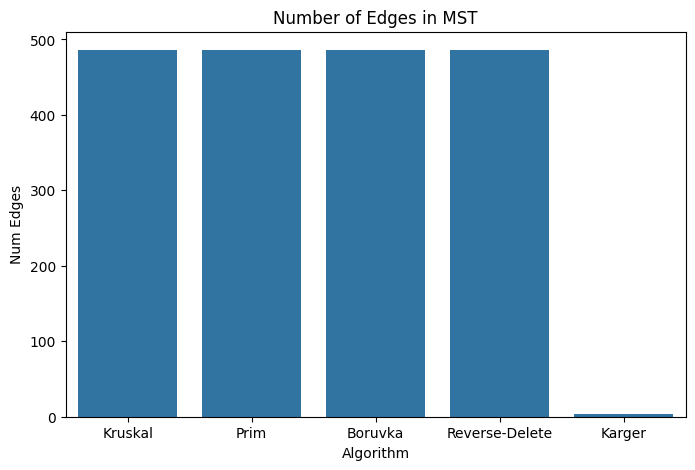

In [17]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Algorithm'})

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x = 'Algorithm', y = 'Time')
plt.title('Execution Time')
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x = 'Algorithm', y = 'Total Weight')
plt.title('MST Total Weight')
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x = 'Algorithm', y = 'Num Edges')
plt.title('Number of Edges in MST')
plt.show()

In [18]:
def animate_mst(original_graph, mst_graph, title="MST Animation", save_path=None):

    fig, ax = plt.subplots(figsize=(10, 7))
    pos = nx.spring_layout(original_graph, seed=42)

    edges = list(mst_graph.edges(data=True))
    frames = []
    temp_graph = nx.Graph()
    temp_graph.add_nodes_from(mst_graph.nodes())

    connected_nodes = set()
    step = 1000
    next_threshold = step

    for u, v, data in edges:
        temp_graph.add_edge(u, v, **data)
        connected_nodes.update([u, v])

        if len(connected_nodes) >= next_threshold:
            frames.append(list(temp_graph.edges(data=True)))
            next_threshold += step

    if not frames or frames[-1] != list(temp_graph.edges(data=True)):
        frames.append(list(temp_graph.edges(data=True)))  # Add final frame if needed

    def update(frame_index):
        ax.clear()
        ax.set_title(title + " - Frame " + str(frame_index + 1) + " / " + str(len(frames)))
        frame_edges = frames[frame_index]
        nx.draw_networkx_nodes(mst_graph, pos, ax=ax, node_size=20)
        nx.draw_networkx_edges(mst_graph, pos, ax=ax, edgelist=frame_edges, edge_color='green', width=2)

    ani = FuncAnimation(fig, update, frames=len(frames), interval=300, repeat=False)

    if save_path:
        ani.save(save_path, writer='pillow')
    plt.close(fig)
    return ani

In [19]:
def save_mst_animation(graphs_dict, original_graph):

    for name, mst in graphs_dict.items():
        if name != "Karger":
            filename = name.lower() + "_mst_animation.gif"
            print("Saving animation for", name)
            animate_mst(original_graph, mst, title=name + " MST", save_path=filename)

In [20]:
def draw_sampled_msts(graphs_dict, original_graph):
    pos = nx.spring_layout(original_graph, seed=42)

    for name, mst in graphs_dict.items():
        if name != "Karger":
            fig, ax = plt.subplots(figsize=(10, 6))
            weights = [d['weight'] for _, _, d in mst.edges(data=True)]

            edges = nx.draw_networkx_edges(mst, pos, ax=ax, edge_color = weights, edge_cmap = plt.cm.viridis, width=1.5)
            nx.draw_networkx_nodes(mst, pos, ax=ax, node_size=20)

            ax.set_title(name + " MST")

            sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
            sm.set_array(weights)
            fig.colorbar(sm, ax=ax, label="Edge Weight")

            plt.show()

In [21]:
save_mst_animation(mst_graphs, G)

Saving animation for Kruskal
Saving animation for Prim
Saving animation for Boruvka
Saving animation for Reverse-Delete


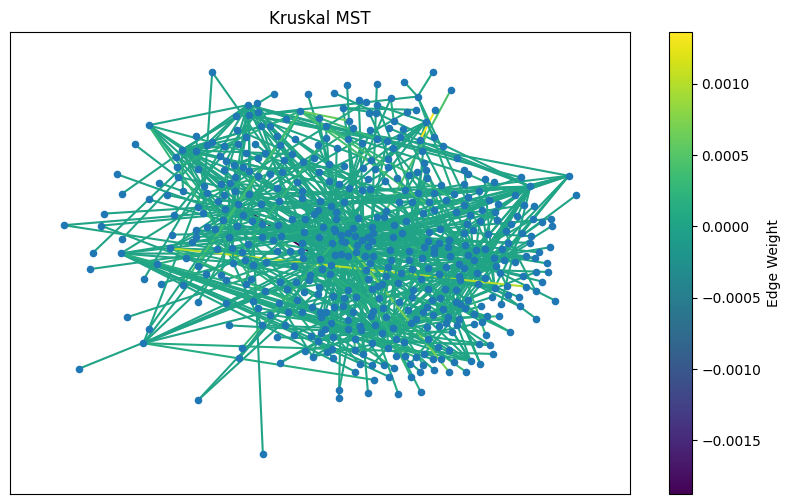

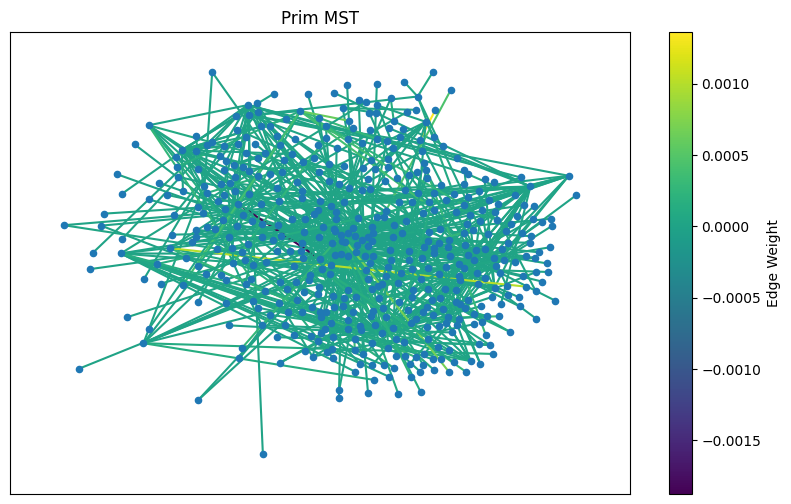

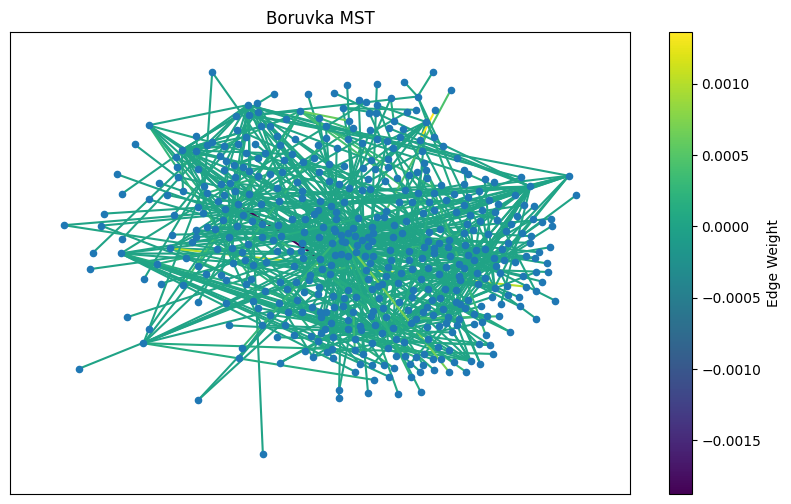

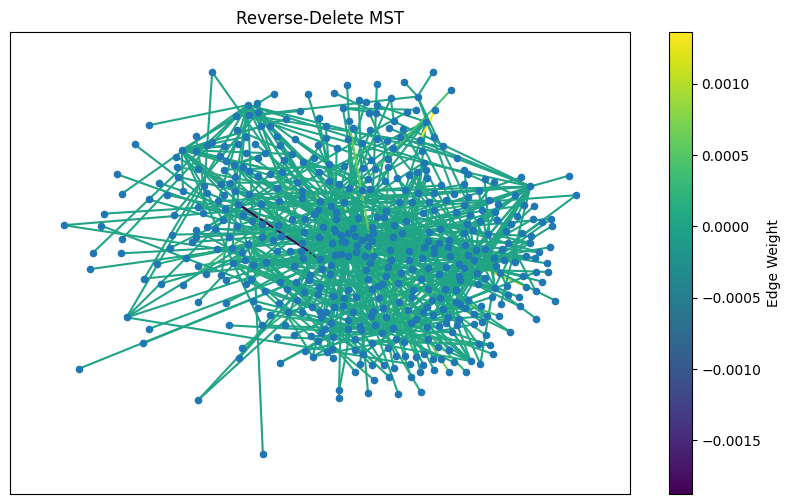

In [22]:
draw_sampled_msts(mst_graphs, G)

In [23]:
network_name = "econ-poli-large"
node_count = G.number_of_nodes()
edge_count = G.number_of_edges()


growth_data = []

for algo_name in ["Kruskal", "Prim", "Boruvka", "Reverse-Delete"]:
    algo_result = results[algo_name]
    entry = {"Algorithm": algo_name, "Network": network_name, "Nodes": node_count, "Edges": edge_count, "Time": algo_result["Time"]}
    growth_data.append(entry)


growth_df = pd.DataFrame(growth_data)
growth_df.to_csv("mst_growth_data_econ_poli_large.csv", index=False)
growth_df

,Algorithm,Network,Nodes,Edges,Time
0,Kruskal,econ-poli-large,496,42090,0.481730
1,Prim,econ-poli-large,496,42090,0.382774
2,Boruvka,econ-poli-large,496,42090,0.370354
3,Reverse-Delete,econ-poli-large,496,42090,93.181013
